In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from time import time
import sys,argparse
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from operator import add
from pyspark.mllib.random import RandomRDDs
import pickle
import pandas

In [8]:
def swap((x,y)):
    return (y,x)

def predict(u,v):
    return np.dot(u, v)

def pred_diff(r,u,v):
    return predict(u, v) - r    

def gradient_u(delta,u,v):
    return 2 * delta * v

def gradient_v(delta,u,v):
    return 2 * delta * u

def readRatings(file,sparkContext):
    return sparkContext.textFile(file).map(lambda x: tuple(x.split(','))).map(lambda (i,j,rij):(int(i),int(j),float(rij)))

def generateUserProfiles(R,d,seed,sparkContext,N):
    print(R, d, seed, N)
    # exctract user ids
    U = R.map(lambda (i,j,rij):i).distinct(numPartitions = N)
    numUsers = U.count()
    randRDD = RandomRDDs.normalVectorRDD(sparkContext, numUsers, d,numPartitions=N, seed=seed)
    U = U.zipWithIndex().map(swap)
    randRDD = randRDD.zipWithIndex().map(swap)
    return U.join(randRDD,numPartitions = N).values()

def generateItemProfiles(R,d,seed,sparkContext,N):
    # extract item ids
    V = R.map(lambda (i,j,rij):j).distinct(numPartitions = N)
    numItems = V.count()
    randRDD = RandomRDDs.normalVectorRDD(sparkContext, numItems, d,numPartitions=N, seed=seed)
    V = V.zipWithIndex().map(swap)
    randRDD = randRDD.zipWithIndex().map(swap)
    return V.join(randRDD,numPartitions = N).values()

def joinAndPredictAll(R,U,V,N):
    return (R.map(lambda (i, j, rij): (i, (j, rij)))
             .join(U, numPartitions = N)
             .map(lambda (i, ((j, rij), ui)): (j, (i, ui, rij)))
             .join(V, numPartitions = N)
             .map(lambda (j, ((i, ui, rij), vj)): (i, j, pred_diff(rij, ui, vj), ui, vj)))


def SE(joinedRDD):
    return joinedRDD.map(lambda (i, j, dij, ui, vj): dij**2).sum()

def normSqRDD(profileRDD,param):
    return param * profileRDD.map(lambda (i, ui): np.linalg.norm(ui)**2).sum()


def adaptU(joinedRDD,gamma,lam,N):
    return (joinedRDD.map(lambda (i, _, dij, ui, vj): (i, (ui, gradient_u(dij, ui, vj))))
                     .reduceByKey(lambda (ui, grad1), (_, grad2): (ui, grad1 + grad2), numPartitions = N)
                     .map(lambda (i, (ui, grad)): (i, ui - gamma * (grad + 2 * lam * ui))))


def adaptV(joinedRDD,gamma,mu,N):
    return (joinedRDD.map(lambda (_, j, dij, ui, vj): (j, (vj, gradient_v(dij, ui, vj))))
                     .reduceByKey(lambda (vj, grad1), (_, grad2): (vj, grad1 + grad2), numPartitions = N)
                     .map(lambda (j, (vj, grad)): (j, vj - gamma * (grad + 2 * mu * vj))))

In [3]:
def get_args(data, 
            folds, 
            gain = 0.001, 
            power = 0.2, 
            epsilon = 1e-99, 
            lam = 1.0, 
            mu = 1.0, 
            d = 10, 
            outputfile = None,
            maxiter = 20, 
            N = 40, 
            seed = 1234567, 
            output = None, 
            verbose=False):
    '''
    Parallele Matrix Factorization.

    positional arguments:
      data                  Directory containing folds. The folds should be named
                            fold0, fold1, ..., foldK.
      folds                 Number of folds

    optional arguments:
      -h, --help            show this help message and exit
      --gain GAIN           Gain (default: 0.001)
      --power POWER         Gain Exponent (default: 0.2)
      --epsilon EPSILON     Desired objective accuracy (default: 1e-99)
      --lam LAM             Regularization parameter for user features (default:
                            1.0)
      --mu MU               Regularization parameter for item features (default:
                            1.0)
      --d D                 Number of latent features (default: 10)
      --outputfile OUTPUTFILE
                            Output file (default: None)
      --maxiter MAXITER     Maximum number of iterations (default: 20)
      --N N                 Parallelization Level (default: 40)
      --seed SEED           Seed used in random number generator (default:
                            1234567)
      --output OUTPUT       If not None, cross validation is skipped, and U,V are
                            trained over entire dataset and store it in files
                            output_U and output_V (default: None)
      --verbose
      --silent
    '''
    import sys

    sys.argv = ['main',
                str(data),
                str(folds),
                '--gain', str(gain),
                '--power', str(power),
                '--epsilon', str(epsilon),
                '--lam', str(lam),
                '--mu', str(mu),
                '--d', str(d),
                '--maxiter', str(maxiter),
                '--N', str(N),
                '--seed', str(seed)]
    
    if outputfile is not None:
        sys.argv += ['--outputfile', str(outputfile)]
        
    if output is not None:
        sys.argv += ['--output', str(output)]
        
    if verbose:
        sys.argv.append('--verbose')
    else:
        sys.argv.append('--silent')
        
    parser = argparse.ArgumentParser(description = 'Parallele Matrix Factorization.',formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('data',help = 'Directory containing folds. The folds should be named fold0, fold1, ..., foldK.')
    parser.add_argument('folds',type = int,help = 'Number of folds')
    parser.add_argument('--gain',default=0.001,type=float,help ="Gain")
    parser.add_argument('--power',default=0.2,type=float,help ="Gain Exponent")
    parser.add_argument('--epsilon',default=1.e-99,type=float,help ="Desired objective accuracy")
    parser.add_argument('--lam',default=1.0,type=float,help ="Regularization parameter for user features")
    parser.add_argument('--mu',default=1.0,type=float,help ="Regularization parameter for item features")
    parser.add_argument('--d',default=10,type=int,help ="Number of latent features")
    parser.add_argument('--outputfile',help = 'Output file')
    parser.add_argument('--maxiter',default=20,type=int, help='Maximum number of iterations')
    parser.add_argument('--N',default=40,type=int, help='Parallelization Level')
    parser.add_argument('--seed',default=1234567,type=int, help='Seed used in random number generator')
    parser.add_argument('--output',default=None, help='If not None, cross validation is skipped, and U,V are trained over entire dataset and store it in files output_U and output_V')

    verbosity_group = parser.add_mutually_exclusive_group(required=False)
    verbosity_group.add_argument('--verbose', dest='verbose', action='store_true')
    verbosity_group.add_argument('--silent', dest='verbose', action='store_false')
    parser.set_defaults(verbose=False)

    return parser.parse_args()     

In [35]:
def train(args, sc):
    folds = {}

#     if args.output is None:
    if args.folds == 1:
        for k in range(5):
            folds[k] = readRatings(args.data+"/fold"+str(k),sc)
    else:
        for k in range(args.folds):
            folds[k] = readRatings(args.data+"/fold"+str(k),sc)
#     else:
#         folds[0] = readRatings(args.data,sc)

    cross_val_rmses = []
    for k in range(args.folds):
        if args.folds == 1:
            k = -1
        train_folds = [folds[j] for j in folds if j is not k]
        train = train_folds[0]
        for fold in train_folds[1:]:
            train = train.union(fold)
        train = train.repartition(N).cache()
        if args.folds == 1:
            test = train
        else:
            test = folds[k].repartition(N).cache()
        Mtrain=train.count()
        Mtest=test.count()

        print("Initiating fold %d with %d train samples and %d test samples" % (k,Mtrain,Mtest) )
#         else:
#             train = folds[k].repartition(args.N).cache()
#             test = train
#             Mtrain=train.count()
#             Mtest=test.count()
#             print("Running single training over training set with %d train samples. Test RMSE computes RMSE on training set" % Mtrain )

        i = 0
        change = 1.e99
        obj = 1.e99

        #Generate user profiles
#         U = generateUserProfiles(train,args.d,args.seed,sc,args.N).cache()
#         V = generateItemProfiles(train,args.d,args.seed,sc,args.N).cache()
        
        U = sc.textFile("../results/mf/u3.csv")
        U = U.map(lambda x: [float(y) for y in x.split(',')]).map(lambda x: (x[0], np.array(x[1:])))
        V = sc.textFile("../results/mf/v3.csv")
        V = V.map(lambda x: [float(y) for y in x.split(',')]).map(lambda x: (x[0], np.array(x[1:])))
        
        U.checkpoint()
        V.checkpoint()

        print "Training set contains %d users and %d items" %(U.count(),V.count())

        start = time()
        gamma = args.gain

        while i<args.maxiter and change > args.epsilon:
            i += 1

            joinedRDD = joinAndPredictAll(train,U,V,args.N).cache()

            oldObjective = obj
            obj = SE(joinedRDD) + normSqRDD(U,args.lam) + normSqRDD(V,args.lam)         
            change = np.abs(obj-oldObjective) 

            testRMSE = np.sqrt(1.*SE(joinAndPredictAll(test,U,V,args.N))/Mtest)

            gamma = args.gain / i**args.power
            U.unpersist()
            V.unpersist()
            U = adaptU(joinedRDD,gamma,args.lam,args.N).cache()
            V = adaptV(joinedRDD,gamma,args.mu,args.N).cache()
            
            u_str = U.map(lambda (x, y): ','.join(str(t) for t in [x] + list(y)))
            v_str = V.map(lambda (x, y): ','.join(str(t) for t in [x] + list(y)))
            
            import shutil
            try:
                shutil.rmtree('../results/mf/u4.csv')
                shutil.rmtree('../results/mf/v4.csv')
            except:
                pass
            u_str.saveAsTextFile('../results/mf/u4.csv')
            v_str.saveAsTextFile('../results/mf/v4.csv')

            now = time()-start
            print "Iteration: %d\tTime: %f\tObjective: %f\tTestRMSE: %f" % (i,now,obj,testRMSE)

            joinedRDD.unpersist()

        cross_val_rmses.append(testRMSE)

        train.unpersist()
        test.unpersist()

    if args.output is None:
       print "%d-fold cross validation error is: %f " % (args.folds, np.mean(cross_val_rmses))
    else:
       print "Saving U and V RDDs"
       U.saveAsTextFile(args.output+'_U')
       V.saveAsTextFile(args.output+'_V')
    return U, V, np.mean(cross_val_rmses)

In [5]:
SparkContext.setSystemProperty('spark.executor.memory', '100g')
SparkContext.setSystemProperty('spark.driver.memory', '100g')
try:
    sc = SparkContext('local[40]', appName='Parallel MF')
except:
    sc = SparkContext.getOrCreate()
    SparkContext.stop(sc)
    sc = SparkContext('local[40]', appName='Parallel MF')
spark = SparkSession(sc)
sc.setLogLevel("ERROR")   
sc.setCheckpointDir('checkpoint/')
sess = SparkSession(sc)

In [5]:
# SparkContext.stop(sc)
conf = pyspark.SparkConf()
# conf.set('spark.local.dir', '/scratch/liu.che')
# conf.set('spark.local.dirs', '/scratch/liu.che')
# conf.set('spark.worker.dir', '/scratch/liu.che')
SparkContext.setSystemProperty('spark.executor.memory', '100g')
SparkContext.setSystemProperty('spark.driver.memory', '100g')
sc = SparkContext("spark://10.99.248.40:7077", appName='Parallel MF')
sc.setCheckpointDir('/scratch/liu.che/ParallelProcessingFinal/src/checkpoint/')
sc.setLogLevel("WARN")   
sess = SparkSession(sc)

In [ ]:
epsilon = 1e-99 
outputfile = 'output'
N = 40
seed = 1234567 
output = 'output' 
verbose = False

fold_nums = 1
gain = 0.00025
data_name = '../data/beer'
power = 0.18
maxiter = 1000

results = []
lam = 0.08
mu = 0.08
d = 20
# for lam in range(0, 1):
#     for mu in range(0, 1):
#         for d in range(4, 5):

print('---------------------------------------')
print('lam: {}, mu: {}, d: {}'.format(lam, mu, d))
args = get_args(data_name, fold_nums, gain, power, epsilon, 
                 lam, mu, d, outputfile, maxiter, N, seed, 
                 output, verbose)
U, V, rms = train(args, sc)
# results.append((lam, mu, d, rms))
# with open('../results/mf/beer.pickle', 'wb+') as f:
#     pickle.dump(results, f)
# with open('../results/mf/beer.txt', 'ab+') as f:
#     f.write('{} {} {} {}\n'.format(lam, mu, d, rms))

---------------------------------------
lam: 0.08, mu: 0.08, d: 20
Initiating fold -1 with 1518478 train samples and 1518478 test samples
Training set contains 32908 users and 49000 items
Iteration: 181	Time: 33.083643	Objective: 2315839.066205	TestRMSE: 1.202547
Iteration: 182	Time: 70.225092	Objective: 2288675.889894	TestRMSE: 1.195073
Iteration: 183	Time: 108.461919	Objective: 2331007.810173	TestRMSE: 1.206692
Iteration: 184	Time: 139.264964	Objective: 2303726.232567	TestRMSE: 1.199211
Iteration: 185	Time: 177.878432	Objective: 2345493.050307	TestRMSE: 1.210637
Iteration: 186	Time: 211.764554	Objective: 2311898.813636	TestRMSE: 1.201452
Iteration: 187	Time: 247.709197	Objective: 2347962.788010	TestRMSE: 1.211307
Iteration: 188	Time: 282.403178	Objective: 2305540.535923	TestRMSE: 1.199707
Iteration: 189	Time: 319.567430	Objective: 2334107.026865	TestRMSE: 1.207534
Iteration: 190	Time: 354.656592	Objective: 2284913.262449	TestRMSE: 1.194031
Iteration: 191	Time: 384.847148	Objective: 2

Iteration: 285	Time: 3641.085861	Objective: 1417618.936536	TestRMSE: 0.924335
Iteration: 286	Time: 3677.694511	Objective: 1406638.860463	TestRMSE: 0.920406
Iteration: 287	Time: 3715.329333	Objective: 1406268.134331	TestRMSE: 0.920281
Iteration: 288	Time: 3748.365384	Objective: 1395619.690952	TestRMSE: 0.916454
Iteration: 289	Time: 3786.228623	Objective: 1395126.086999	TestRMSE: 0.916283
Iteration: 290	Time: 3820.565120	Objective: 1384790.927677	TestRMSE: 0.912553
Iteration: 291	Time: 3856.031529	Objective: 1384173.773118	TestRMSE: 0.912337
Iteration: 292	Time: 3892.073994	Objective: 1374136.144615	TestRMSE: 0.908699
Iteration: 293	Time: 3931.110113	Objective: 1373396.735794	TestRMSE: 0.908438
Iteration: 294	Time: 3966.095937	Objective: 1363644.194817	TestRMSE: 0.904887
Iteration: 295	Time: 4004.163258	Objective: 1362786.439976	TestRMSE: 0.904582
Iteration: 296	Time: 4039.925640	Objective: 1353309.880806	TestRMSE: 0.901117
Iteration: 297	Time: 4074.414246	Objective: 1352340.342572	TestR

In [9]:
u_str = U.map(lambda (x, y): ','.join(str(t) for t in [x] + list(y)))
v_str = V.map(lambda (x, y): ','.join(str(t) for t in [x] + list(y)))

In [10]:
u_str.take(2)

['0,-0.7297006140244157,1.4962763020067322,0.3896103832776914,-1.8935152510699058',
 '20480,1.040386587960158,0.01828241501710274,0.27204776714854917,-1.146878199684007']

In [11]:
u_str.saveAsTextFile('u.csv')
v_str.saveAsTextFile('v.csv')

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

with open('/scratch/liu.che/Assignment4/results/{}_results_d_search.pickle'.format('large_data'), 'rb') as f:
    res = pickle.load(f)
    df = pd.DataFrame()
#     df = pd.DataFrame({
#         'lam': list(range(9)),
#         'mu': list(range(9)),
#         'd': [4] * 9,
#         'rms': [105.232653602, 105.243649287, 105.260565961, 105.283086419, 105.310910376, 105.343753562, 
#                105.381346878, 105.423435582, 105.469778531],
#     })

for r in res:
    lam, mu, d, rms = r
    df = df.append({'lam': lam, 'mu': mu, 'd': d, 'rms': rms}, ignore_index = True)

IOError: [Errno 2] No such file or directory: '/scratch/liu.che/Assignment4/results/large_data_results_d_search.pickle'

In [162]:
df

,d,lam,mu,rms
0,4.0,0.0,0.0,105.232654
1,4.0,1.0,1.0,105.243649
2,4.0,2.0,2.0,105.260566
3,4.0,3.0,3.0,105.283086
4,4.0,4.0,4.0,105.310910
5,4.0,5.0,5.0,105.343754
6,4.0,6.0,6.0,105.381347
7,4.0,7.0,7.0,105.423436
8,4.0,8.0,8.0,105.469779
9,4.0,9.0,9.0,105.520147


In [138]:
df.loc[df.rms == df.rms.min()]

,d,lam,mu,rms
0,4.0,0.0,0.0,105.232654


Text(0,0.5,'rms')

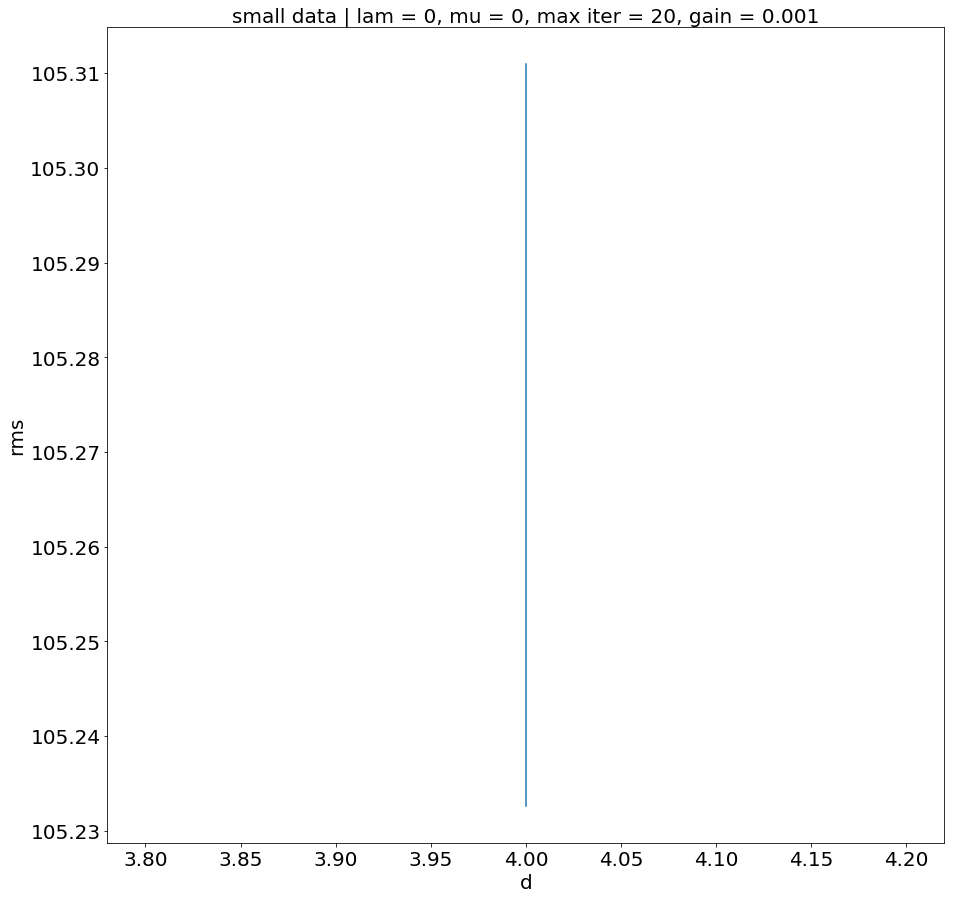

In [139]:
ax = df.plot(x = 'd', y = 'rms', figsize=(15, 15), fontsize = 20)
ax.legend().remove()
plt.title('small data | lam = 0, mu = 0, max iter = 20, gain = 0.001', fontsize = 20)
plt.xlabel('d', fontsize = 20)
plt.ylabel('rms', fontsize = 20)

Text(0,0.5,'RMSE')

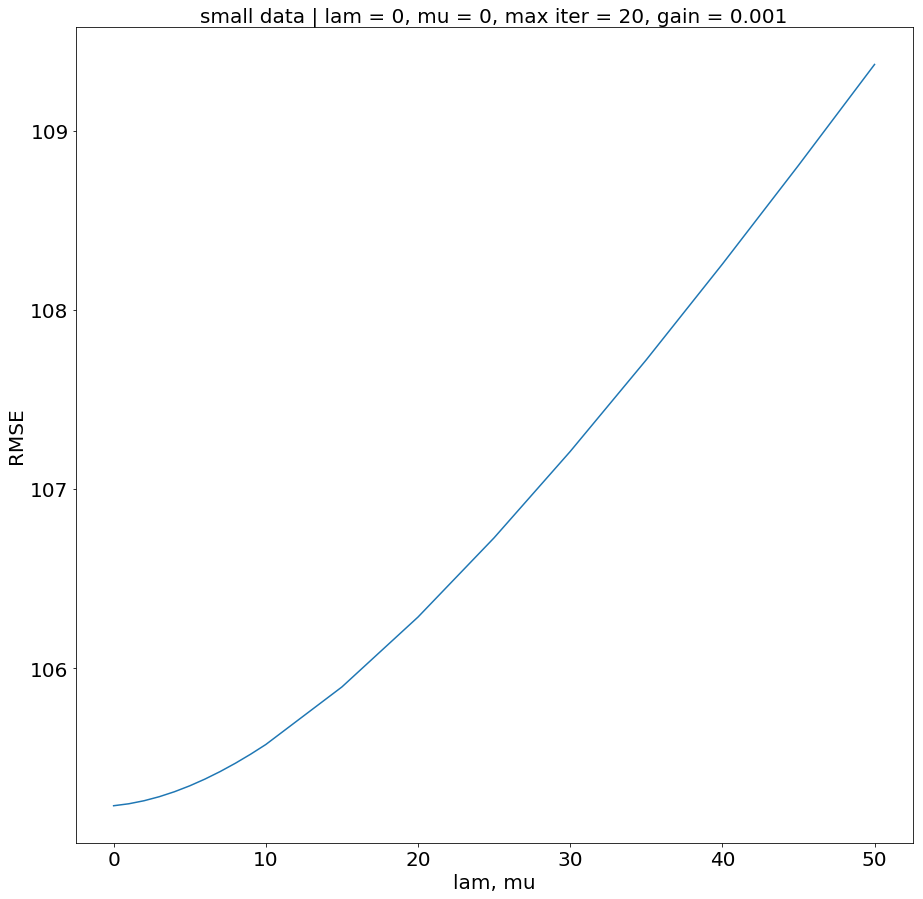

In [164]:
ax = df.plot(x = 'lam', y = 'rms', figsize=(15, 15), fontsize = 20)
ax.legend().remove()
plt.title('small data | lam = 0, mu = 0, max iter = 20, gain = 0.001', fontsize = 20)
plt.xlabel('lam, mu', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)

In [11]:
fold = readRatings("../data/beer/fold1", sc)
U = generateUserProfiles(fold, 20, 1234567, sc, 40).cache()

(PythonRDD[135] at RDD at PythonRDD.scala:52, 20, 1234567, 40)


In [12]:
U.take(1)

[(0, array([-0.72551146,  1.85940327,  0.4104733 , -2.53729421,  1.05863149,
          0.0196546 ,  0.27508785, -1.16457253,  0.31716855,  0.41583083,
          0.12743458, -0.82384867,  1.54730952,  1.0500534 ,  0.43983164,
          0.45228982,  1.15280251, -2.51800159,  0.97968085, -0.34868922]))]

In [13]:
U = sc.textFile("../results/mf/u3.csv")

In [28]:
U.map(lambda x: [float(y) for y in x.split(',')]).map(lambda x: (x[0], np.array(x[1:]))).take(1)

[(10247.0,
  array([ 0.08972171, -1.31794637, -1.001958  ,  0.92173932,  1.16543417,
          0.08344267, -1.18675174, -1.07674837,  0.66245898, -0.08441233,
         -0.67128721, -1.34148699, -1.01729769,  2.10446981, -1.0913939 ,
          0.88118514,  0.13338759,  0.91223803, -0.3510713 ,  1.47979747]))]